In [317]:
from abc import ABC, abstractmethod
from typing import Any
import numpy as np

MAX_INFRASTRUCTURE_COST_EFFECT = 1
INFRASTRUCTURE_MAX_LEVEL = 5

CIV_COST = 10800
MILL_COST = 7200
INFRA_COST = 3600

MILL_OUT = 4.5
CIV_OUT = 5

YEAR = 365

class economy:
    def __init__(self, startingCivs:int, startingMills:int, infrastructure:int):
        self.civs = startingCivs
        self.mills = startingMills
        self.infrastructure = infrastructure
    def createRunner(self, decisionMaker:'decisionMaker') -> 'economyRunner':
        return economyRunner(self, decisionMaker)
        
class decisionMaker(ABC):
    @abstractmethod
    def __init__(self):
        pass
    @abstractmethod
    def makeDecision(self, runner:'economyRunner') -> None:
        pass
    
class ratioMaker(decisionMaker):
    def __init__(self, civToMillRatio:float):
        self.civToMillRatio = civToMillRatio
    def makeDecision(self, runner:'economyRunner') -> None:
        if runner.civs / runner.mills > self.civToMillRatio:
            runner.buildMill()
        else:
            runner.buildCiv()

class cutOffMaker(decisionMaker):
    def __init__(self, civCutOff:int):
        self.civCutOff = civCutOff
    def makeDecision(self, runner:'economyRunner') -> None:
        if runner.day < self.civCutOff:
            runner.buildCiv()
        else:
            runner.buildMill()

class economyRunner:
    def __init__(self, economy:economy, decisionMaker:decisionMaker):
        self.civs = economy.civs
        self.mills = economy.mills
        self.infrastructure = economy.infrastructure
        self.millScore = 0
        self.civScore = 0
        self.decisionMaker = decisionMaker
        self.day = 0
    def getInfrastuctureBonus(self) -> float:
        return 1 + (self.infrastructure * (MAX_INFRASTRUCTURE_COST_EFFECT / INFRASTRUCTURE_MAX_LEVEL))
    def tick(self):
        self.day += 1
        self.millScore += self.mills * MILL_OUT
        self.civScore += self.civs * CIV_OUT * self.getInfrastuctureBonus()
        self.decisionMaker.makeDecision(self)
    def buildCiv(self) -> None:
        if self.civScore > CIV_COST:
            self.civScore -= CIV_COST
            self.civs += 1
    def buildMill(self) -> None:
        if self.civScore > MILL_COST:
            self.civScore -= MILL_COST
            self.mills += 1
    def buildInfrastructure(self) -> None:
        if self.civScore > INFRA_COST:
            self.civScore -= INFRA_COST
            self.infrastructure += 1

def graphResults(results:dict[Any, tuple[int, int]], xaxis:str="Day", title:str="Mills vs Civs") -> None:
    import matplotlib.pyplot as plt
    plt.plot(results.keys(), [x[0] for x in results.values()], label="Mills")
    plt.plot(results.keys(), [x[1] for x in results.values()], label="Civs")
    
    max_mills_day = max(results, key=lambda x: results[x][0])
    plt.axvline(x=max_mills_day, color='r', linestyle='--')
    maxOverall = max(results, key=lambda x: results[x][0] + results[x][1])
    plt.axvline(x=maxOverall, color='g', linestyle='--')
    
    plt.legend()
    plt.xlabel(xaxis)
    plt.ylabel("Number")
    plt.title(title)
    plt.show()



# Hoi4 economy simulation

This jupyter notebook performs some hoi4 economy simulation in order to determine the optimal strategy for economy.
The goal isn't to get accurate numbers, but to generally model how player action impacts the economy.

## Simulation

The simulation allows users to determine the starting state of the economy, the average infrastructure level in the country, and the economy decision making alorithm.
However it ignores the tech level of the country, and the military factory production modifiers.
These shouldn't have that much of an impact on the results.
The simulation is performed on Germany starting stats from 1936.

## Decision makers

I preprogramed in two decision maker classes.
One is called the cutOffMaker and it stops building civs and entirely switches constructions to military factories after a given timespan in days.
The other is called ratioMaker and it constructs factories in such a way to keep the given ratio between civilian factories and military factories.

## ratioMaker Tests

Below some simulated comparison tests are performed on the ratioMaker economy model.
The general performance when compared to the cutoff model is tested.
The results generally seem inconclusive.
In the second cell the performance when compared with the given ratio input is graphed.
The green dotted line indicates the ratio where the sum of the civilian factory count and the military factory count are the highest.
On the other hand the red dotted line indicates where the military factory count in the highest.

In [350]:
yearMaker = cutOffMaker(365)
fifthMaker = ratioMaker(0.2)

germany = economy(31, 28, 3)

yearRunner = germany.createRunner(yearMaker)
fifthRunner = germany.createRunner(fifthMaker)

for day in range(0, YEAR * 3):
    yearRunner.tick()
    fifthRunner.tick()

print(f"Year Runner:{yearRunner.millScore}")
print(f"Ratio Runner:{fifthRunner.millScore}")


Year Runner:191839.5
Ratio Runner:228348.0


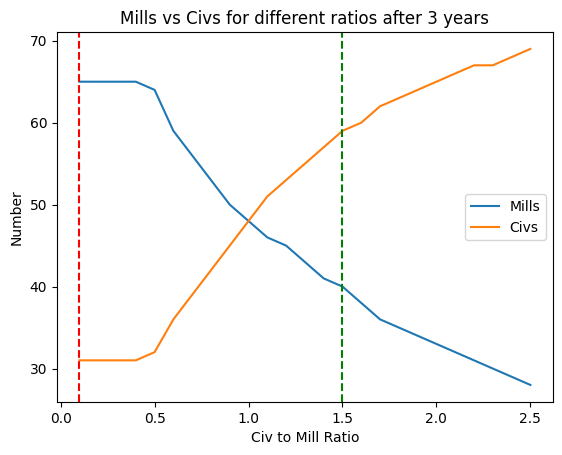

In [351]:
result:dict[float, tuple[int, int]] = {}

timeScale = 3
for ratio in range(1, 26, 1):
    ratio = ratio/10
    maker = ratioMaker(ratio)
    ratioRunner = germany.createRunner(maker)
    for day in range(0, YEAR * timeScale):
        ratioRunner.tick()
    result[ratio] = (ratioRunner.mills, ratioRunner.civs)
    
graphResults(result, "Civ to Mill Ratio", f"Mills vs Civs for different ratios after {timeScale} years")

## Switch months

The cutOffMarker decision maker determines to switch the economy to full military production on the given month.
In order to best determine that month the economic performance compared to the month in which the production gets switched is graphed below.
It seems that while the civilian factory count plot retains it's shape regardless of the simulated timespan, the military factory count plot changes it's shape based on the simulated timespan.
This means that the optimal switch month changes depending on the tested time frame.

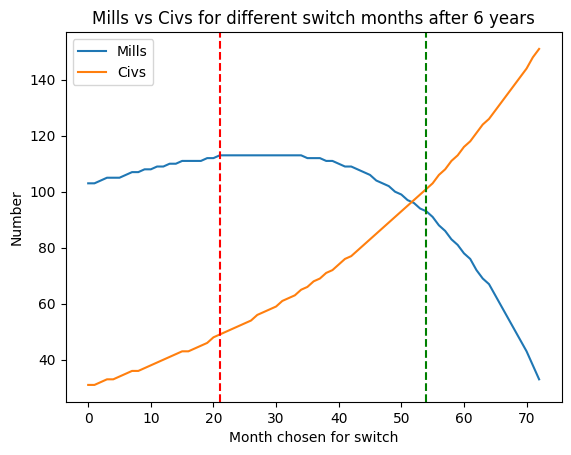

In [367]:

def simulateCutoff(timeScale:int):
    results:dict[int, tuple[int, int]] = {}
    for month in range(0, (12 * timeScale) + 1, 1):
        maker = cutOffMaker(month*30)
        monthRunner = germany.createRunner(maker)
        for day in range(0, YEAR * timeScale):
            monthRunner.tick()
        results[month] = (monthRunner.mills, monthRunner.civs)
    return results

timeScale = 6
graphResults(simulateCutoff(timeScale), "Month chosen for switch", f"Mills vs Civs for different switch months after {timeScale} years")


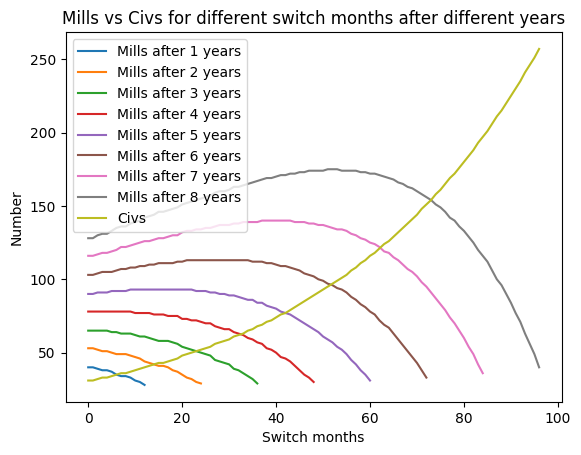

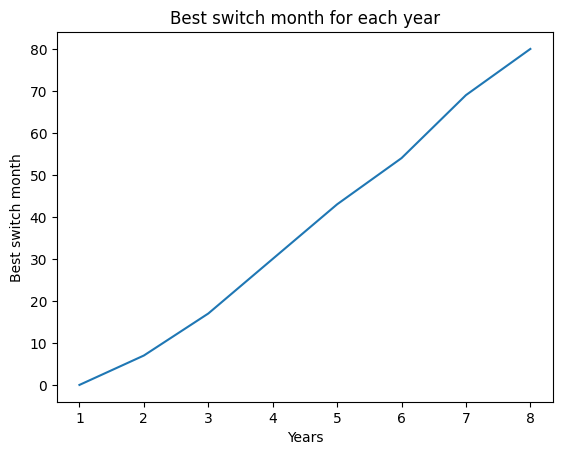

[0, 7, 17, 30, 43, 54, 69, 80]


In [368]:
import matplotlib.pyplot as plt

all = []
result = {}
for i in range(1, 9):
    result = simulateCutoff(i)
    all.append(result)
    plt.plot(result.keys(), [x[0] for x in result.values()], label=f"Mills after {i} years")

plt.plot(result.keys(), [x[1] for x in result.values()], label=f"Civs")

plt.legend()
plt.xlabel("Switch months")
plt.ylabel("Number")
plt.title(f"Mills vs Civs for different switch months after different years")
plt.show()

#find the best cutoff for each year
bestCutoffs = []
for year in all:
    bestCutoffs.append(max(year, key=lambda x: year[x][0] + year[x][1]))

#graph the best switch month for each year
plt.plot(range(1, 9), bestCutoffs)
plt.xlabel("Years")
plt.ylabel("Best switch month")
plt.title(f"Best switch month for each year")
plt.show()

print(bestCutoffs)

